In [ ]:
import paddle
from paddle import ParamAttr
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn import Conv2D,BatchNorm,Linear,Dropout,AdaptiveAvgPool2D,MaxPool2D,AvgPool2D
import numpy as np
import PIL
from sklearn.neighbors import KNeighborsRegressor
import os
from skimage import io
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
import math

In [ ]:
means = np.array([0.485, 0.456, 0.406])
# 风格图片的路径
image_style = io.imread('D:\DiffusionModel\style_image.jpg') 
image_style = image_style[:,:,:3]# 因为我的图片的维度是4(rgba)，所以在这里取3维(rgb)
image_style = resize(image_style, (384,512))
image_style = (image_style - means) * 255
# 想要迁移风格的图片的路径
image_content = io.imread('D:\DiffusionModel\content2.jpg')
image_content = image_content[:,:,:3] 
sz = image_content.shape[:2]
image_content = resize(image_content, (384,512))
image_content = (image_content - means) * 255
 
image_transfer = 0.3*image_content + 0.7*np.random.randint(-20, 20, (image_content.shape[0],image_content.shape[1],image_content.shape[2]))
print('初始化的迁移图像：')
plt.imshow(PIL.Image.fromarray(np.uint8(image_transfer/255+means)))
plt.show()
image_transfer = paddle.to_tensor(image_transfer[:,:,:,None].transpose([3,2,0,1]).astype('float32'), stop_gradient=False)

In [ ]:
class ConvBlock(nn.Layer):
    def __init__(self, input_channels, output_channels, groups, name=None):
        super(ConvBlock, self).__init__()
 
        self.groups = groups
        self._conv_1 = Conv2D(
            in_channels=input_channels,
            out_channels=output_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            weight_attr=ParamAttr(name=name + "1_weights"),
            bias_attr=False)
        if groups == 2 or groups == 3 or groups == 4:
            self._conv_2 = Conv2D(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                weight_attr=ParamAttr(name=name + "2_weights"),
                bias_attr=False)
        if groups == 3 or groups == 4:
            self._conv_3 = Conv2D(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                weight_attr=ParamAttr(name=name + "3_weights"),
                bias_attr=False)
        if groups == 4:
            self._conv_4 = Conv2D(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                weight_attr=ParamAttr(name=name + "4_weights"),
                bias_attr=False)
 
        # self._pool = MaxPool2D(kernel_size=2, stride=2, padding=0)
        self._pool = AvgPool2D(kernel_size=2, stride=2, padding=0)
 
    def forward(self, inputs):
        conv1 = self._conv_1(inputs)
        x = F.relu(conv1)
        if self.groups == 2 or self.groups == 3 or self.groups == 4:
            conv2 = self._conv_2(x)
            x = F.relu(conv2)
        if self.groups == 3 or self.groups == 4:
            x = self._conv_3(x)
            x = F.relu(x)
        if self.groups == 4:
            x = self._conv_4(x)
            x = F.relu(x)
        x = self._pool(x)
        return x, conv1, conv2

In [ ]:
 
class VGGNet(nn.Layer):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.groups = [2, 2, 4, 4, 4]
        self._conv_block_1 = ConvBlock(3, 64, self.groups[0], name="conv1_")
        self._conv_block_2 = ConvBlock(64, 128, self.groups[1], name="conv2_")
        self._conv_block_3 = ConvBlock(128, 256, self.groups[2], name="conv3_")
        self._conv_block_4 = ConvBlock(256, 512, self.groups[3], name="conv4_")
        self._conv_block_5 = ConvBlock(512, 512, self.groups[4], name="conv5_")
 
    def forward(self, inputs):
        x, conv1_1, _ = self._conv_block_1(inputs)
        x, conv2_1, _ = self._conv_block_2(x)
        x, conv3_1, _ = self._conv_block_3(x)
        x, conv4_1, conv4_2 = self._conv_block_4(x)
        _, conv5_1, _ = self._conv_block_5(x)
        return conv4_2, conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

In [ ]:
def adam(image_transfer, m, v, g, t, η, β1=0.9, β2=0.999, ε=1e-8):
    m = β1*m + (1-β1)*g
    v = β2*v + (1-β2)*g**2
    m_hat = m / (1 - β1**t)
    v_hat = v / (1 - β2**t)
    image_transfer -= η*m_hat / (paddle.sqrt(v_hat) + ε)
    return image_transfer, m, v

In [ ]:
# 内容损失
def contentloss(content, transfer):
    return 0.5 * paddle.sum((content - transfer)**2)
# 计算Gram矩阵
def gram(feature):
    _, c, h, w = feature.shape
    feature = feature.reshape([c,h*w])
    return paddle.matmul(feature, feature.transpose([1,0]))
# 风格损失
def styleloss(style, transfer, weight):
    loss = 0
    for i in range(len(style)):
        gram_style = gram(style[i])
        gram_transfer = gram(transfer[i])
        _, c, h, w = style[i].shape
        loss += weight[i] * paddle.sum((gram_style - gram_transfer)**2) / (2*c*h*w)**2
    return loss
 
# 定义trainer函数通过调用上面的函数实现函数的调用
def trainer(image_transfer, m, v, net, features_content, features_style, t, η):
    features_transfer = net(image_transfer)
    loss_content = contentloss(features_content[0], features_transfer[0])
    weight_style = [0.5,1.0,1.5,3.0,4.0]
    loss_style = styleloss(features_style[1:], features_transfer[1:], weight_style)
    loss = 1e0*loss_content + 1e3*loss_style
    net.clear_gradients()
    gradients = paddle.grad(loss, image_transfer)[0] 
    m,v=0,0
    image_transfer, m, v = adam(image_transfer, m, v, gradients, t, η)
    return image_transfer, m, v

In [ ]:
 
def train(image_transfer, net, epoch_num):
    features_content = net(paddle.to_tensor(image_content[:,:,:,None].transpose([3,2,0,1]).astype('float32')))
    features_style = net(paddle.to_tensor(image_style[:,:,:,None].transpose([3,2,0,1]).astype('float32')))
    m = paddle.zeros_like(image_transfer)
    v = paddle.zeros_like(image_transfer)
 
    for epoch in range(epoch_num):
        image_transfer, m, v = trainer(image_transfer, m, v, net, features_content, features_style, epoch+1, 2)
 
        if (epoch) % 50 == 0:
            print('Epoch: ', epoch+1)
            im = np.squeeze(image_transfer.numpy().transpose([2,3,1,0]))
            im = im/255 + means
            im = resize(im, sz)
            im = PIL.Image.fromarray(np.uint8(im*255))
            plt.imshow(im)
            plt.show()
 
 

In [ ]:
vgg19 = VGGNet()
vgg19.set_state_dict(paddle.load('D:\DiffusionModel\work\VGG19_pretrained.pdparams'))
vgg19.eval()

Epoch:  1


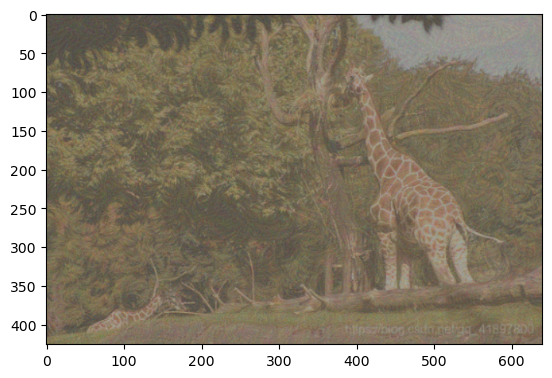

Epoch:  51


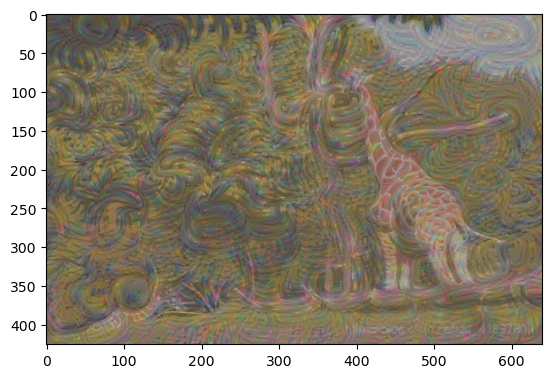

Epoch:  101


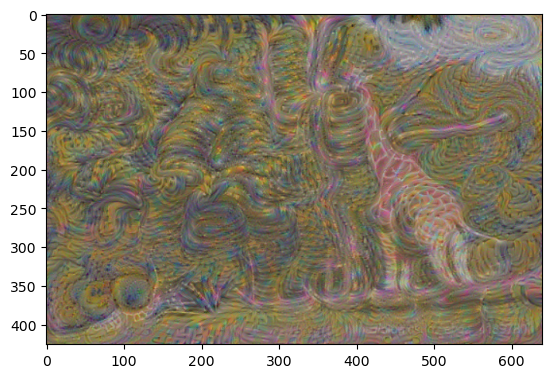

Epoch:  151


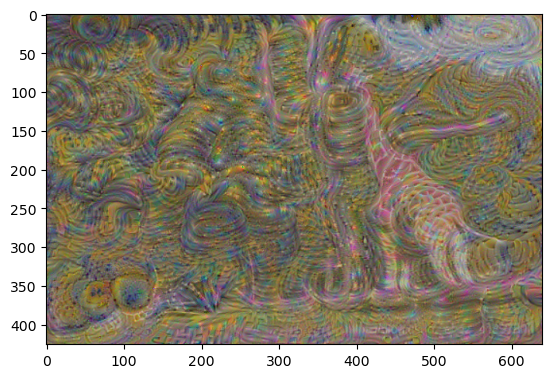

Epoch:  201


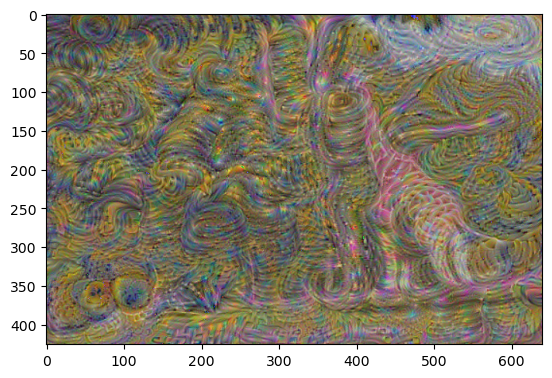

Epoch:  251


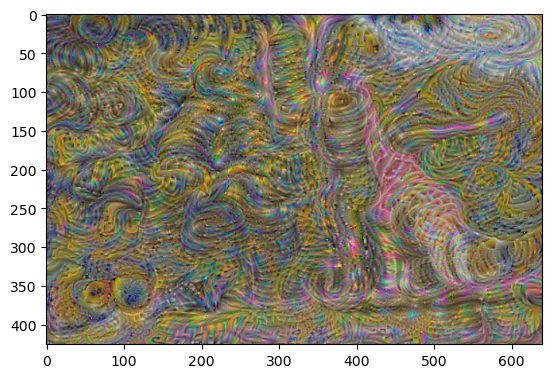

Epoch:  301


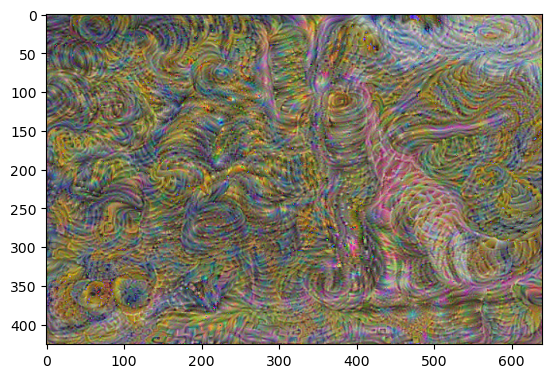

Epoch:  351


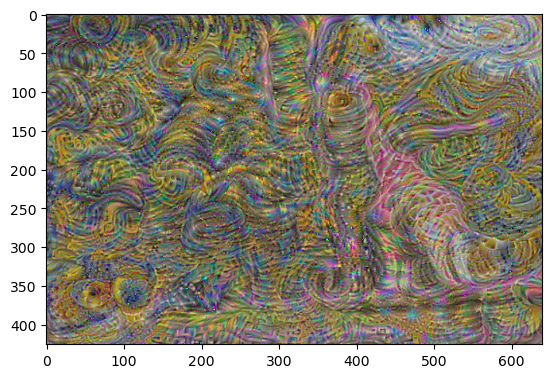

Epoch:  401


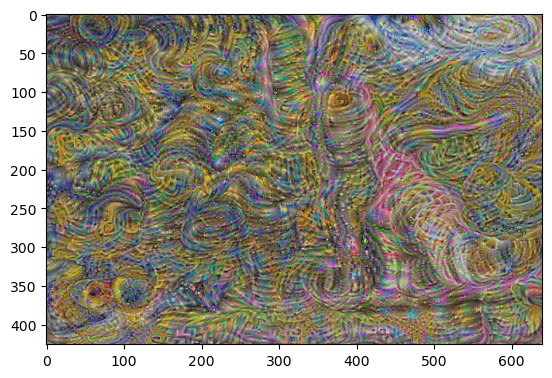

Epoch:  451


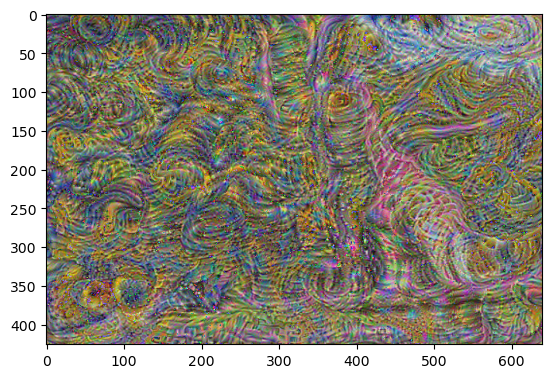

Epoch:  501


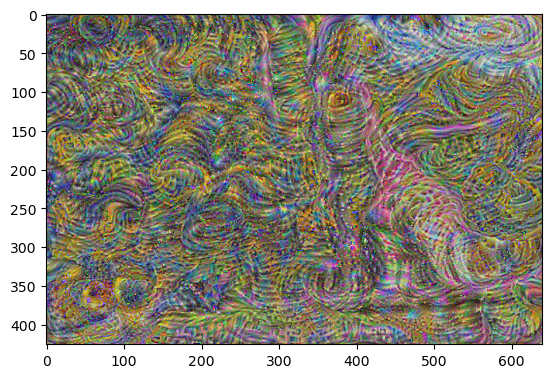

Epoch:  551


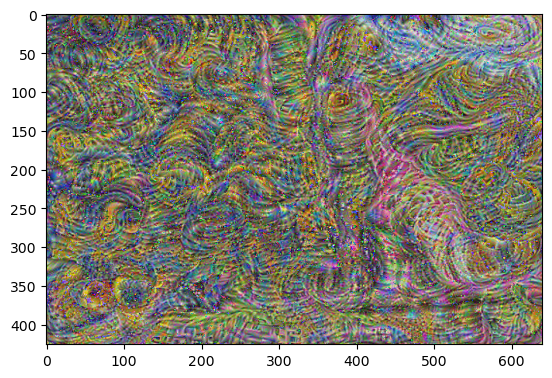

Epoch:  601


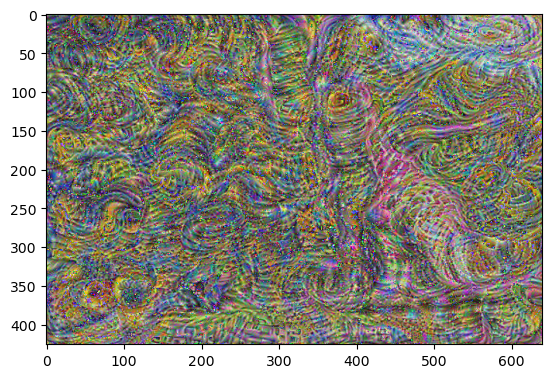

Epoch:  651


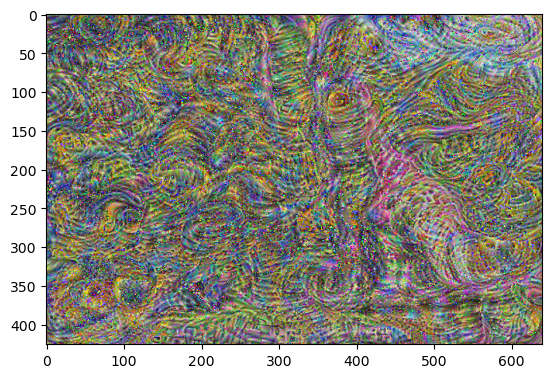

Epoch:  701


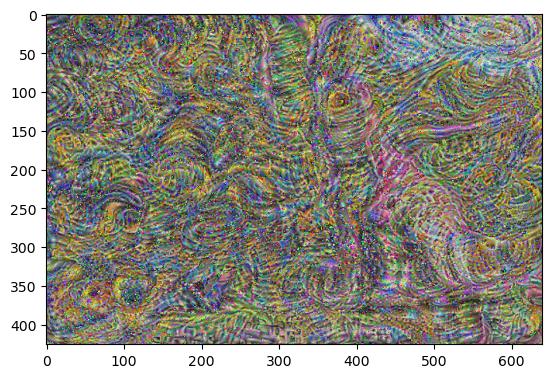

Epoch:  751


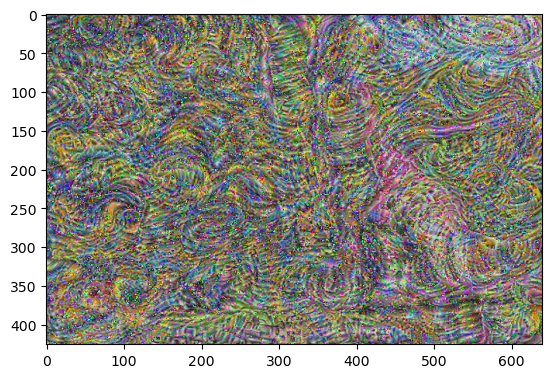

KeyboardInterrupt: 

In [10]:
train(image_transfer, vgg19, 250)